In [4]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error, roc_curve, auc, roc_auc_score, recall_score, accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE

import itertools
import os 
os.chdir('e:/ml_data/kaggle_data/')

In [5]:
df = pd.read_csv('./heart_disease_uci.csv')
df = df.drop(['dataset', 'id'], axis=1)
df = df.iloc[:303, :]

In [6]:
cate_cols = [col for col in df.columns if df[col].nunique() < 10]
uniques = [(df[col].nunique(), col) for col in cate_cols]

In [7]:
df[df['thal'].isna()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
87,53,Female,non-anginal,128.000,216.000,False,lv hypertrophy,115.000,False,0.000,upsloping,0.000,NaN,0
266,52,Male,asymptomatic,128.000,204.000,True,normal,156.000,True,1.000,flat,0.000,NaN,2


In [8]:
df[df['ca'].isna()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
166,52,Male,non-anginal,138.000,223.000,False,normal,169.000,False,0.000,upsloping,NaN,normal,0
192,43,Male,asymptomatic,132.000,247.000,True,lv hypertrophy,143.000,True,0.100,flat,NaN,reversable defect,1
287,58,Male,atypical angina,125.000,220.000,False,normal,144.000,False,0.400,flat,NaN,reversable defect,0
302,38,Male,non-anginal,138.000,175.000,False,normal,173.000,False,0.000,upsloping,NaN,normal,0


In [9]:
df['thal'].value_counts()

thal
normal               166
reversable defect    117
fixed defect          18
Name: count, dtype: int64

In [10]:
df[df['target'] == 0]['thal'].value_counts()

thal
normal               129
reversable defect     28
fixed defect           6
Name: count, dtype: int64

In [11]:
df[df['target'] == 2]['thal'].value_counts()

thal
reversable defect    22
normal                7
fixed defect          6
Name: count, dtype: int64

In [12]:
df['ca'].fillna(0., inplace=True)

C:\Users\fxinw\AppData\Local\Temp\ipykernel_52536\194182310.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ca'].fillna(0., inplace=True)


In [13]:
df.loc[87, 'thal'] = 'normal'
df.loc[266, 'thal'] = 'reversable defect'

In [14]:
or_encoder = OrdinalEncoder()
df[cate_cols] = pd.DataFrame(or_encoder.fit_transform(df[cate_cols])).astype(int)

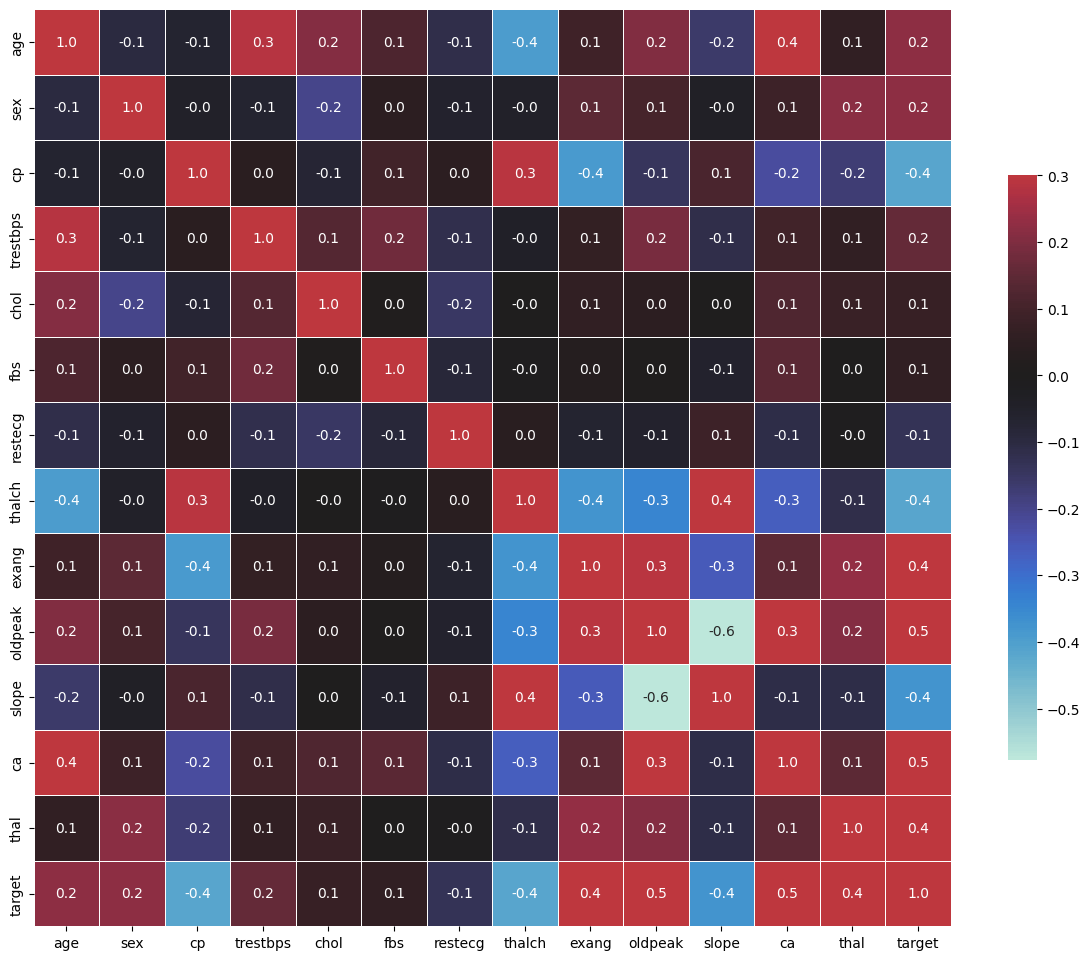

In [15]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), vmax=0.3, center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink':0.5}, annot=True, fmt='.1f')
plt.tight_layout()
plt.show()

C:\Users\fxinw\AppData\Local\Temp\ipykernel_52536\3234920688.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

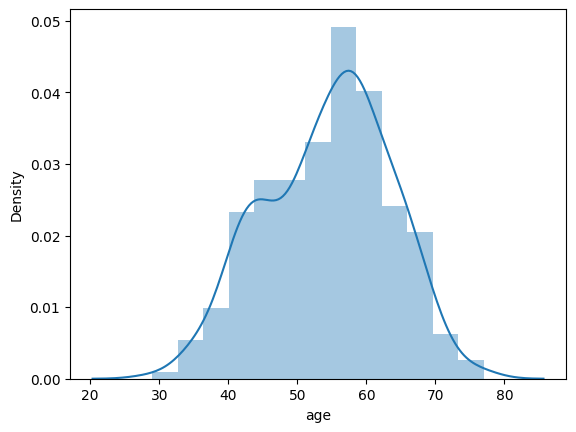

In [16]:
sns.distplot(df['age'])

<Axes: xlabel='target', ylabel='count'>

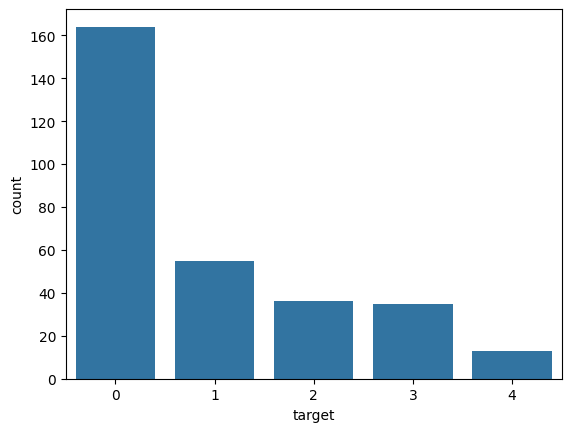

In [17]:
sns.countplot(x='target', data=df)

In [18]:
df.loc[df['target'] > 0, 'target'] = 1

<Axes: xlabel='age'>

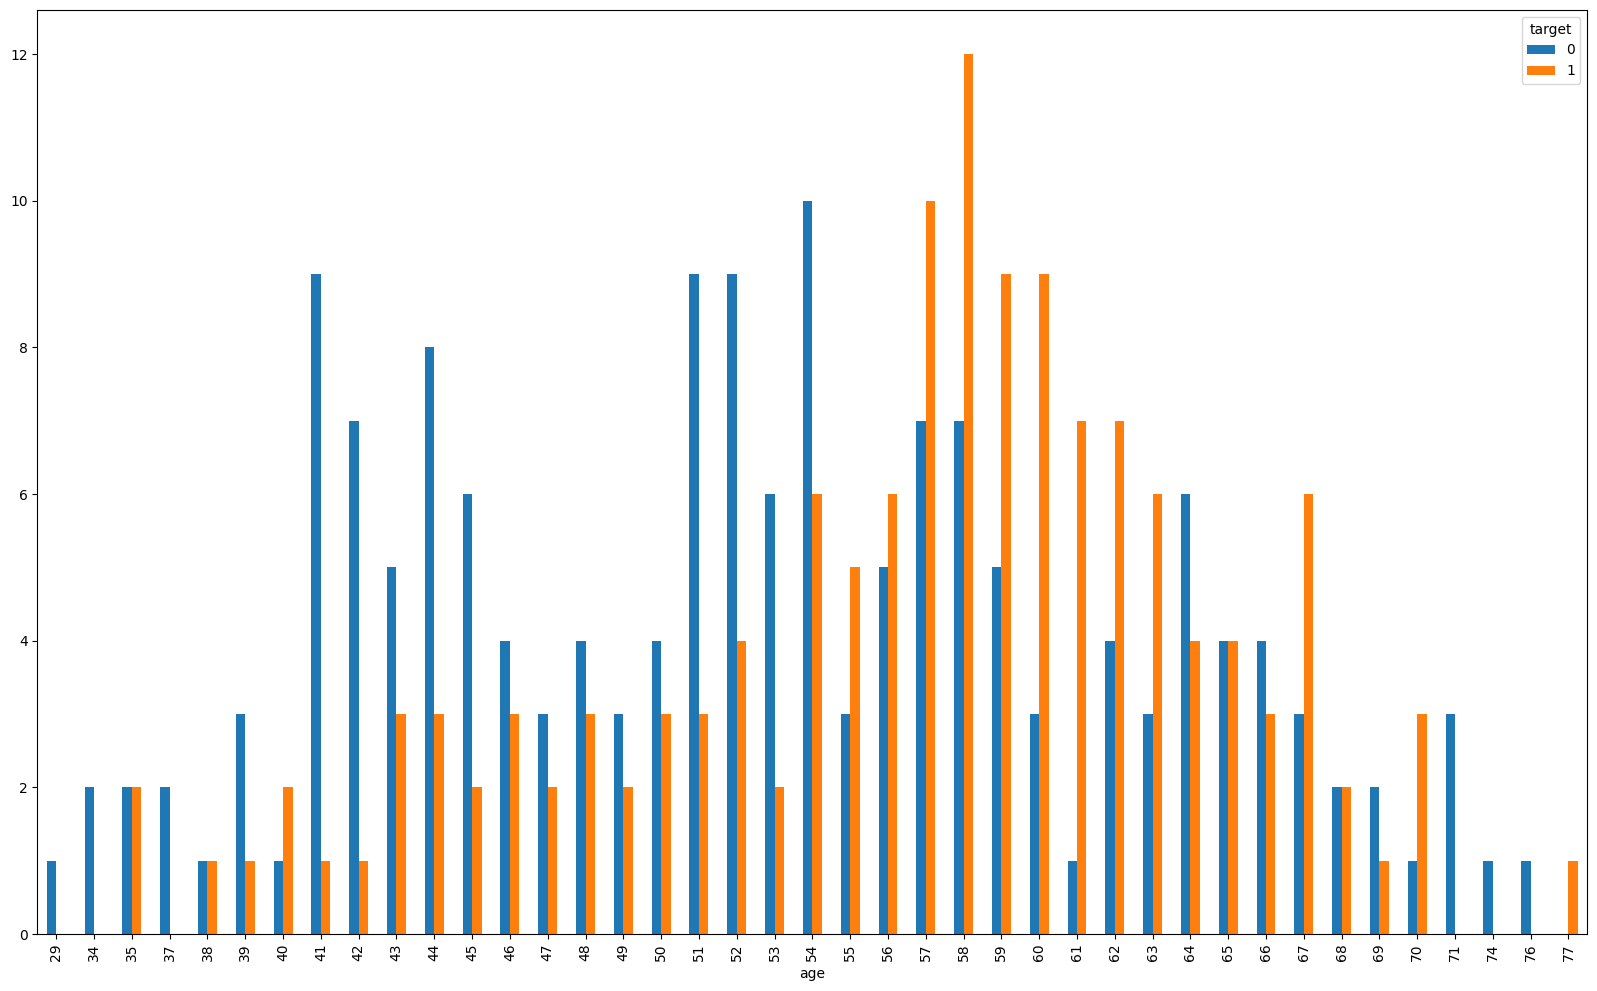

In [19]:
pd.crosstab(df.age, df.target).plot(kind='bar', figsize=(20, 12))

In [20]:
df.columns.drop('oldpeak')

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [21]:
df[df.columns.drop('oldpeak')] = df[df.columns.drop('oldpeak')].astype(int)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int32  
 1   sex       303 non-null    int32  
 2   cp        303 non-null    int32  
 3   trestbps  303 non-null    int32  
 4   chol      303 non-null    int32  
 5   fbs       303 non-null    int32  
 6   restecg   303 non-null    int32  
 7   thalch    303 non-null    int32  
 8   exang     303 non-null    int32  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int32  
 11  ca        303 non-null    int32  
 12  thal      303 non-null    int32  
 13  target    303 non-null    int32  
dtypes: float64(1), int32(13)
memory usage: 17.9 KB


In [23]:
cate_cols.remove('target')
cate_cols.remove('ca')

In [24]:
one_hot_cols = pd.get_dummies(df[cate_cols].astype('category'))

In [25]:
one_hot_cols

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2
0,False,True,False,False,False,True,False,True,True,False,False,True,False,True,False,False,True,False,False
1,False,True,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False
2,False,True,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True
3,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False
4,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,False,True,False,False,False,True,True,False,False,True,False,True,False,False,True,False,False,False,True
299,False,True,True,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False,True
300,False,True,True,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True
301,True,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False


In [26]:
df.drop(cate_cols, axis=1, inplace=True)

In [27]:
cate_cols

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [28]:
one_hot_cols

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2
0,False,True,False,False,False,True,False,True,True,False,False,True,False,True,False,False,True,False,False
1,False,True,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,False
2,False,True,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True
3,False,True,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True,False
4,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,False,True,False,False,False,True,True,False,False,True,False,True,False,False,True,False,False,False,True
299,False,True,True,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False,True
300,False,True,True,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True
301,True,False,False,True,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False


In [29]:
df = df.join(one_hot_cols)

In [30]:
df

,age,trestbps,chol,thalch,oldpeak,ca,target,sex_0,sex_1,cp_0,...,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2
0,63,145,233,150,2.300,0,0,False,True,False,...,False,False,True,False,True,False,False,True,False,False
1,67,160,286,108,1.500,3,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
2,67,120,229,129,2.600,2,1,False,True,True,...,False,False,False,True,False,True,False,False,False,True
3,37,130,250,187,3.500,0,0,False,True,False,...,True,False,True,False,True,False,False,False,True,False
4,41,130,204,172,1.400,0,0,True,False,False,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,110,264,132,1.200,0,1,False,True,False,...,True,False,True,False,False,True,False,False,False,True
299,68,144,193,141,3.400,2,1,False,True,True,...,True,False,True,False,False,True,False,False,False,True
300,57,130,131,115,1.200,1,1,False,True,True,...,True,False,False,True,False,True,False,False,False,True
301,57,130,236,174,0.000,1,1,True,False,False,...,False,False,True,False,False,True,False,False,True,False


In [31]:
df.head()

,age,trestbps,chol,thalch,oldpeak,ca,target,sex_0,sex_1,cp_0,...,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2
0,63,145,233,150,2.300,0,0,False,True,False,...,False,False,True,False,True,False,False,True,False,False
1,67,160,286,108,1.500,3,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
2,67,120,229,129,2.600,2,1,False,True,True,...,False,False,False,True,False,True,False,False,False,True
3,37,130,250,187,3.500,0,0,False,True,False,...,True,False,True,False,True,False,False,False,True,False
4,41,130,204,172,1.400,0,0,True,False,False,...,False,False,True,False,False,False,True,False,True,False


In [33]:
X = df.drop('target', axis=1)
y = df['target']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [98]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm, accuracy_score(y_true=y_test, y_pred=y_pred)

D:\miniconda\envs\ptc\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(array([[31,  4],
        [ 8, 18]], dtype=int64),
 0.8032786885245902)

In [127]:
model = XGBClassifier(n_estimators=200, learning_rate=0.1)
model.fit(
    X_train, y_train,
)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[32,  3],
       [10, 16]], dtype=int64)

In [136]:
GBC = LogisticRegression()
kfold = StratifiedKFold(n_splits=6)
gb_param_grid = {
    # 'loss': ['deviance'],
    'C': [1, 3, 5],
    # 'learning_rate': [0.1, 0.05, 0.01],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
    'l1_ratio': [0., 0.1, 0.3]
}
modelgsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1)
modelgsGBC.fit(X_train, y_train)
cm = confusion_matrix(y_test, modelgsGBC.predict(X_test))
cm

Fitting 5 folds for each of 36 candidates, totalling 180 fits


D:\miniconda\envs\ptc\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


array([[30,  5],
       [ 8, 18]], dtype=int64)

In [126]:
accuracy_score(modelgsGBC.predict(X_test), y_test)

0.7868852459016393

In [128]:
for m in [model, modelgsGBC]:
    print(f"accuracy_score for model: {accuracy_score(m.predict(X_test), y_test)}")

accuracy_score for model: 0.7868852459016393
accuracy_score for model: 0.7868852459016393


In [69]:
def cnf_matrix_plotter(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confsion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black',
                 fontsize=25
                 )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

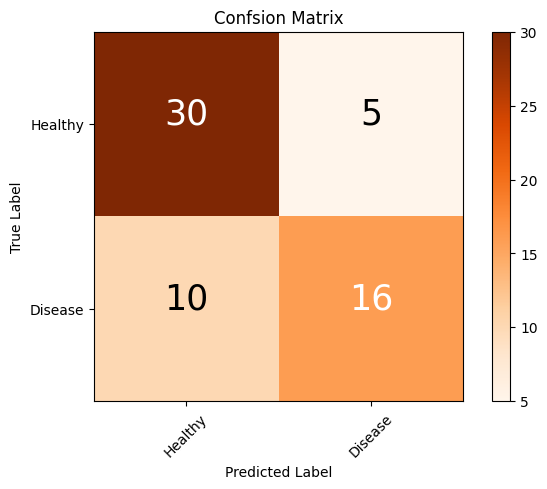

In [70]:
cnf_matrix_plotter(cm, ['Healthy', 'Disease'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=['healthy', 'disease']))

<Figure size 640x480 with 0 Axes>

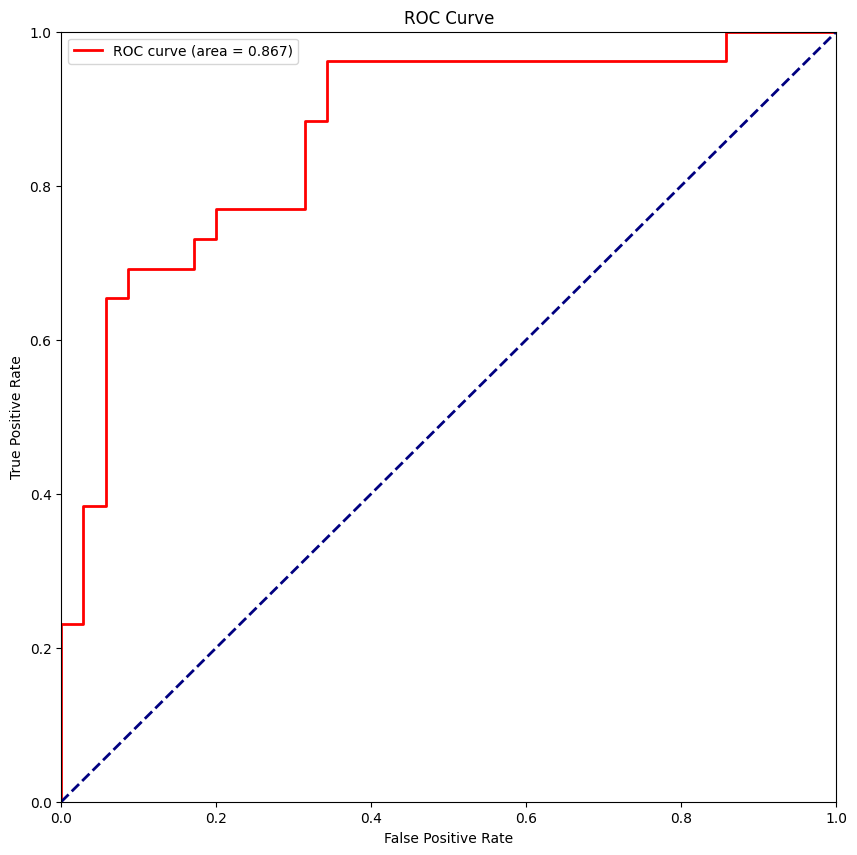

In [139]:
fpr, tpr, threshold = roc_curve(y_test, modelgsGBC.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()